In [12]:
import tensorflow as tf
# from tensorflow.examples.tutorials.mnist import input_data
import numpy as np
from PIL import Image
from scipy import misc
import os
# import imageio
import matplotlib.pyplot as plt
%matplotlib inline

In [13]:
batch_size = 100
g_dim = 128

ls = np.array(os.listdir("./img_align_celeba"))

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 2, 2, 1], padding = 'SAME')
def deconv2d(x, W, output_shape):
    return tf.nn.conv2d_transpose(x, W, output_shape, strides = [1, 2, 2, 1], padding = 'SAME')


In [14]:
def get_image(img_path):
#     img = misc.imread(img_path)/255. - 0.5
    img = misc.imread(img_path)
#     img = img[..., ::-1]  # rgb to bgr
    return img

def batch(batch_size, ls):
    index = (np.random.sample(batch_size)*202599).astype(int)
    ls_x = ls[[index]]
    return np.array([np.reshape(misc.imread("./img_align_celeba/"+x), 116412)/255. for x in ls_x])

class layer:
    def __init__(self, in_size, out_size):
        self.W = tf.Variable(tf.random_normal([in_size, out_size], mean=0.0, stddev=0.1))
        self.b = tf.Variable(tf.random_normal([1, out_size], mean=0.0, stddev=0.1))
    def output(self, inputs, activation_function=None):
        if activation_function == None:
            return tf.matmul(inputs, self.W) + self.b
        else :
            return activation_function(tf.matmul(inputs, self.W) + self.b)

def weight_variable(shape):
    initial = tf.random_normal(shape, mean=0.0, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.random_normal(shape, mean=0.0, stddev=0.1)
    return tf.Variable(initial)

In [20]:
layer_e = layer(28*23*64, g_dim)
layer_d = layer(g_dim, 28*23*64)

encoder_var = {
    "W_e_conv1" : weight_variable([3,3, 3,16]),
    "W_e_conv2" : weight_variable([3,3,16,32]),
    "W_e_conv3" : weight_variable([3,3,32,64]),
#     "W_e_conv3" : weight_variable([3,3,64,128]),
    "b_e_conv1" : bias_variable([16]),   
    "b_e_conv2" : bias_variable([32]),
    "b_e_conv3" : bias_variable([64])
#     "b_e_conv3" : bias_variable([128])
}

decoder_var = {
    "W_d_conv1" : weight_variable([3,3,32,64]),
    "W_d_conv2" : weight_variable([3,3,16,32]),
    "W_d_conv3" : weight_variable([3,3, 3,16]),
    "b_d_conv1" : bias_variable([32]),
    "b_d_conv2" : bias_variable([16]),
    "b_d_conv3" : bias_variable([3])
}

generator_var = {
    "W_d_conv1" : weight_variable([3,3,32,64]),
    "W_d_conv2" : weight_variable([3,3,16,32]),
    "W_d_conv3" : weight_variable([3,3, 3,16]),
    "b_d_conv1" : bias_variable([32]),
    "b_d_conv2" : bias_variable([16]),
    "b_d_conv3" : bias_variable([3])
}

var_d = [encoder_var[e] for e in encoder_var]+[decoder_var[d] for d in decoder_var]
var_g = [generator_var[g] for g in generator_var]


In [21]:
def encoder(x):
    x_origin = tf.reshape(x, [-1,218,178,3])      #28x28x1
    h_e_conv1 = tf.nn.relu(tf.add(conv2d(x_origin, encoder_var["W_e_conv1"]), encoder_var["b_e_conv1"]))     #14x14x16
    h_e_conv2 = tf.nn.relu(tf.add(conv2d(h_e_conv1, encoder_var["W_e_conv2"]), encoder_var["b_e_conv2"]))    #7x7x32
    h_e_conv3 = tf.nn.relu(tf.add(conv2d(h_e_conv2, encoder_var["W_e_conv3"]), encoder_var["b_e_conv3"]))    #4x4x64
    h_e_conv3_reshape = tf.reshape(h_e_conv3, [-1,28*23*64])
    h_e_layer = layer_e.output(h_e_conv3_reshape, tf.nn.relu)
#     h_e_layer = layer_e.output(h_e_conv3_reshape, tf.nn.sigmoid)
    return h_e_layer
    
def decoder(z):
    h_d_layer = layer_d.output(z, tf.nn.relu)
#     h_d_layer = layer_d.output(z, tf.nn.sigmoid)
    h_d_layer_reshape = tf.reshape(h_d_layer, [-1,28,23,64])
    
    output_shape_d_conv1 = tf.stack([tf.shape(z)[0], 55, 45, 32])
    h_d_conv1 = tf.nn.relu(deconv2d(h_d_layer_reshape, decoder_var["W_d_conv1"], output_shape_d_conv1)+decoder_var["b_d_conv1"])

    output_shape_d_conv1 = tf.stack([tf.shape(z)[0], 109, 89, 16])
    h_d_conv2 = tf.nn.relu(deconv2d(h_d_conv1, decoder_var["W_d_conv2"], output_shape_d_conv1)+decoder_var["b_d_conv2"])

    output_shape_d_conv2 = tf.stack([tf.shape(z)[0], 218, 178, 3])
    h_d_conv3 = tf.nn.relu(deconv2d(h_d_conv2, decoder_var["W_d_conv3"], output_shape_d_conv2)+decoder_var["b_d_conv3"])
    return h_d_conv3

def generator(z):
    h_d_layer = layer_d.output(z, tf.nn.relu)
#     h_d_layer = layer_d.output(z, tf.nn.sigmoid)
    h_d_layer_reshape = tf.reshape(h_d_layer, [-1,28,23,64])
    
    output_shape_d_conv1 = tf.stack([tf.shape(z)[0], 55, 45, 32])
    h_d_conv1 = tf.nn.relu(deconv2d(h_d_layer_reshape, generator_var["W_d_conv1"], output_shape_d_conv1)+generator_var["b_d_conv1"])

    output_shape_d_conv1 = tf.stack([tf.shape(z)[0], 109, 89, 16])
    h_d_conv2 = tf.nn.relu(deconv2d(h_d_conv1, generator_var["W_d_conv2"], output_shape_d_conv1)+generator_var["b_d_conv2"])

    output_shape_d_conv2 = tf.stack([tf.shape(z)[0], 218, 178, 3])
    h_d_conv3 = tf.nn.relu(deconv2d(h_d_conv2, generator_var["W_d_conv3"], output_shape_d_conv2)+generator_var["b_d_conv3"])
    return h_d_conv3

def discriminator(x):
    return decoder(encoder(x))

In [22]:
def sample_Z(m, n):
    return np.random.uniform(-1., 1., size=[m, n])

def loss(x):
#     return tf.reduce_mean(tf.pow(tf.reshape(x, [-1, 784]) - tf.reshape(discriminator(x), [-1, 784]), 2))
    return tf.reduce_mean(tf.abs(tf.reshape(x, [-1, 116412]) - tf.reshape(discriminator(x), [-1, 116412])))
#     return tf.pow(tf.reshape(x, [-1, 784]) - tf.reshape(discriminator(x), [-1, 784]), 2)

In [23]:
x_d = tf.placeholder(tf.float32, shape = [None, 116412])
x_g = tf.placeholder(tf.float32, shape = [None, g_dim])


gamma = 0.5
# k_t = 0.
k_t = tf.Variable(0.0, tf.float32)

# d_loss = loss(x_d)-k_t*loss(generator(x_g))
# d_loss = loss(x_d)
d_loss = tf.reduce_mean(loss(x_d)-k_t*loss(generator(x_g)))
# g_loss = loss(generator(x_g))
g_loss = tf.reduce_mean(loss(generator(x_g)))

g_sample = generator(x_g)

M_global = loss(x_d) + tf.abs(gamma*loss(x_d) - loss(generator(x_g)))

d_optimizer = tf.train.AdamOptimizer(0.00001).minimize(d_loss, var_list= var_d)
g_optimizer = tf.train.AdamOptimizer(0.00001).minimize(g_loss, var_list= var_g)

# balancer = gamma*loss(x_d) - loss(generator(x_g))
balancer = tf.reduce_mean(gamma*loss(x_d) - loss(generator(x_g)))
update_k = k_t.assign(k_t + 0.001 * balancer)



In [24]:
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

for step in range(1001):
    batch_x = batch(batch_size, ls)
    z_D = sample_Z(batch_size, g_dim)
    sess.run([d_optimizer, g_optimizer], feed_dict={x_d: batch_x, x_g: z_D})
    z_G = sample_Z(batch_size, g_dim)
    sess.run(g_optimizer, feed_dict={x_g: z_G})
#     k_t = np.maximum(np.minimum(1., k_t + 0.001*(sess.run(balancer, feed_dict={x_d: batch_x, x_g: z_G}))), 0.)
    sess.run(update_k, feed_dict={x_d: batch_x, x_g: z_G})
    if step%100==0:
        d_loss_train, g_loss_train, M_global_train = sess.run([d_loss, g_loss, M_global], feed_dict=
                            {x_d: batch_x, x_g: sample_Z(batch_size, g_dim)})
#         print 'step:', step, ' d-loss:', d_loss_train, ' g-loss:', g_loss_train, 'k_t:', k_t,"M_global:", M_global_train
        print 'step:', step, ' d-loss:', d_loss_train, ' g-loss:', g_loss_train, 'k_t:', sess.run(k_t),"M_global:", M_global_train

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  # Remove the CWD from sys.path while we load stuff.


step: 0  d-loss: 0.425209  g-loss: 0.164476 k_t: 4.82592e-05 M_global: 0.473348
step: 100  d-loss: 0.397492  g-loss: 0.119339 k_t: 0.00653989 M_global: 0.478069
step: 200  d-loss: 0.387458  g-loss: 0.0987145 k_t: 0.0147374 M_global: 0.484655
step: 300  d-loss: 0.36524  g-loss: 0.089813 k_t: 0.0237308 M_global: 0.461244
step: 400  d-loss: 0.355099  g-loss: 0.0888103 k_t: 0.0329343 M_global: 0.448226
step: 500  d-loss: 0.368972  g-loss: 0.0888146 k_t: 0.0418628 M_global: 0.470221
step: 600  d-loss: 0.351616  g-loss: 0.0892332 k_t: 0.0504478 M_global: 0.444943
step: 700  d-loss: 0.33543  g-loss: 0.0919426 k_t: 0.0585509 M_global: 0.419278
step: 800  d-loss: 0.343131  g-loss: 0.0955117 k_t: 0.0659916 M_global: 0.42864
step: 900  d-loss: 0.328512  g-loss: 0.103448 k_t: 0.0726798 M_global: 0.400599
step: 1000  d-loss: 0.320257  g-loss: 0.109453 k_t: 0.0783995 M_global: 0.383804


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  # Remove the CWD from sys.path while we load stuff.


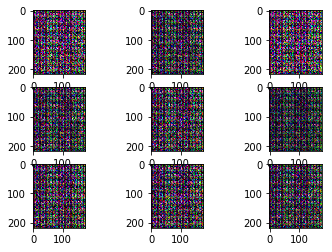

In [28]:
# zz = sample_Z(batch_size, g_dim)
# gg = sess.run(g_sample, feed_dict = {x_g: zz})
# gg = sess.run(g_sample, feed_dict = {x_g: sample_Z(batch_size, g_dim)})
gg = sess.run(discriminator(x_d), feed_dict = {x_d: batch(20, ls)})
gg_pic = np.array([np.reshape(m,(218,178,3)) for m in gg])
fig, ax = plt.subplots(nrows=3, ncols=3)
for i,row in enumerate(ax):
    for j,col in enumerate(row):
        ax[i][j].imshow(gg_pic[i*3+j])

In [ ]:
for step in range(5001):
    batch_x = batch(batch_size, ls)
    z_D = sample_Z(batch_size, g_dim)
    sess.run([d_optimizer, g_optimizer], feed_dict={x_d: batch_x, x_g: z_D})
    z_G = sample_Z(batch_size, g_dim)
    sess.run(g_optimizer, feed_dict={x_g: z_G})
#     k_t = np.maximum(np.minimum(1., k_t + 0.001*(sess.run(balancer, feed_dict={x_d: batch_x, x_g: z_G}))), 0.)
    sess.run(update_k, feed_dict={x_d: batch_x, x_g: z_G})
    if step%100==0:
        d_loss_train, g_loss_train, M_global_train = sess.run([d_loss, g_loss, M_global], feed_dict=
                            {x_d: batch_x, x_g: sample_Z(batch_size, g_dim)})
#         print 'step:', step, ' d-loss:', d_loss_train, ' g-loss:', g_loss_train, 'k_t:', k_t,"M_global:", M_global_train
        print 'step:', step, ' d-loss:', d_loss_train, ' g-loss:', g_loss_train, 'k_t:', sess.run(k_t),"M_global:", M_global_train

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  # Remove the CWD from sys.path while we load stuff.


step: 0  d-loss: 0.313273  g-loss: 0.109739 k_t: 0.07845 M_global: 0.373084
step: 100  d-loss: 0.326014  g-loss: 0.115528 k_t: 0.0832945 M_global: 0.387928
step: 200  d-loss: 0.30801  g-loss: 0.122036 k_t: 0.0873335 M_global: 0.355966
step: 300  d-loss: 0.2933  g-loss: 0.126139 k_t: 0.0905692 M_global: 0.330948
step: 400  d-loss: 0.297555  g-loss: 0.130144 k_t: 0.0931403 M_global: 0.33437
step: 500  d-loss: 0.287902  g-loss: 0.135198 k_t: 0.0950731 M_global: 0.315936
step: 600  d-loss: 0.279555  g-loss: 0.140308 k_t: 0.0961295 M_global: 0.299256
step: 700  d-loss: 0.274465  g-loss: 0.135886 k_t: 0.096835 M_global: 0.295549
step: 800  d-loss: 0.267789  g-loss: 0.131037 k_t: 0.0979788 M_global: 0.289904
step: 900  d-loss: 0.269997  g-loss: 0.134626 k_t: 0.0989329 M_global: 0.290347
step: 1000  d-loss: 0.257429  g-loss: 0.14466 k_t: 0.0988607 M_global: 0.280525
step: 1100  d-loss: 0.255127  g-loss: 0.156275 k_t: 0.0973937 M_global: 0.291448
step: 1200  d-loss: 0.247866  g-loss: 0.154303 k

In [11]:
b=batch(100, ls)
b.shape

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  # Remove the CWD from sys.path while we load stuff.


(100, 116412)